In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from glob import glob
mpl.style.use('ggplot')

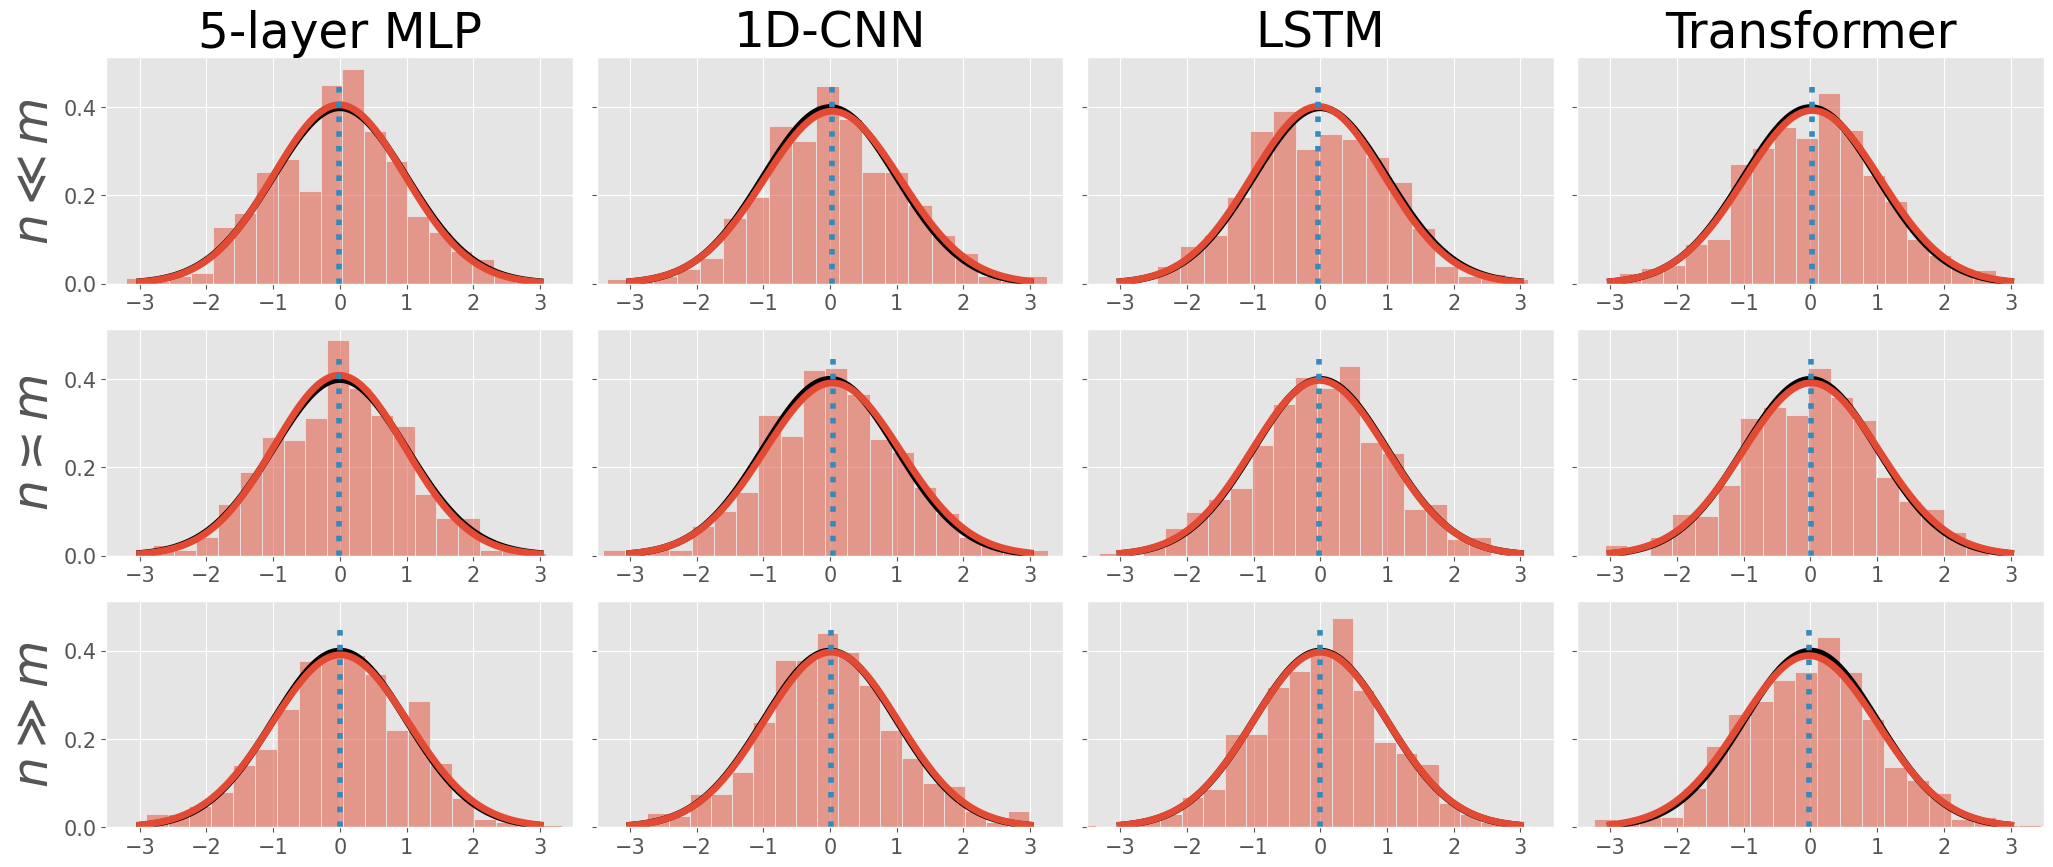

In [7]:
path = glob("res/*.csv")
path = [glob("res/mat*mlp.csv")[0], glob("res/mat*cnn.csv")[0], glob("res/mat*rnn.csv")[0], glob("res/mat*tr.csv")[0]]
path

xxx = np.linspace(-3,3,100)
titles = ["5-layer MLP", "1D-CNN", "LSTM", "Transformer"]
ylabels = [r"$n \ll m$", r"$n\asymp m$", r"$n\gg m$"]
fig, ax = plt.subplots(3,4,figsize=(25, 10), sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.2);
for i in range(4):
    df = pd.read_csv(path[i], header=None).values
    ax[0,i].set_title(titles[i], fontsize=35);
    for j in range(3):
        ax[j,i].plot(xxx, np.exp(-xxx**2/2)/np.sqrt(2*np.pi), color="black", lw=5);
        sns.histplot(df[j], stat="density", alpha=0.5, ax=ax[j,i]);
        mean, std = np.mean(df[j]), np.std(df[j])
        ax[j,i].plot(xxx, np.exp(-(xxx-mean)**2/2/std**2)/np.sqrt(2*np.pi)/std, color="C0", lw=5);
        ax[j,i].vlines(mean, 0, 0.45, linestyle="dotted", lw=4, color="C1");
        ax[j,0].set_ylabel(ylabels[j], fontsize=35);
        ax[j,i].set_xlim(-3.5,3.5);
        ax[j,i].tick_params(labelsize=15);
plt.savefig('asyN.pdf', bbox_inches='tight')

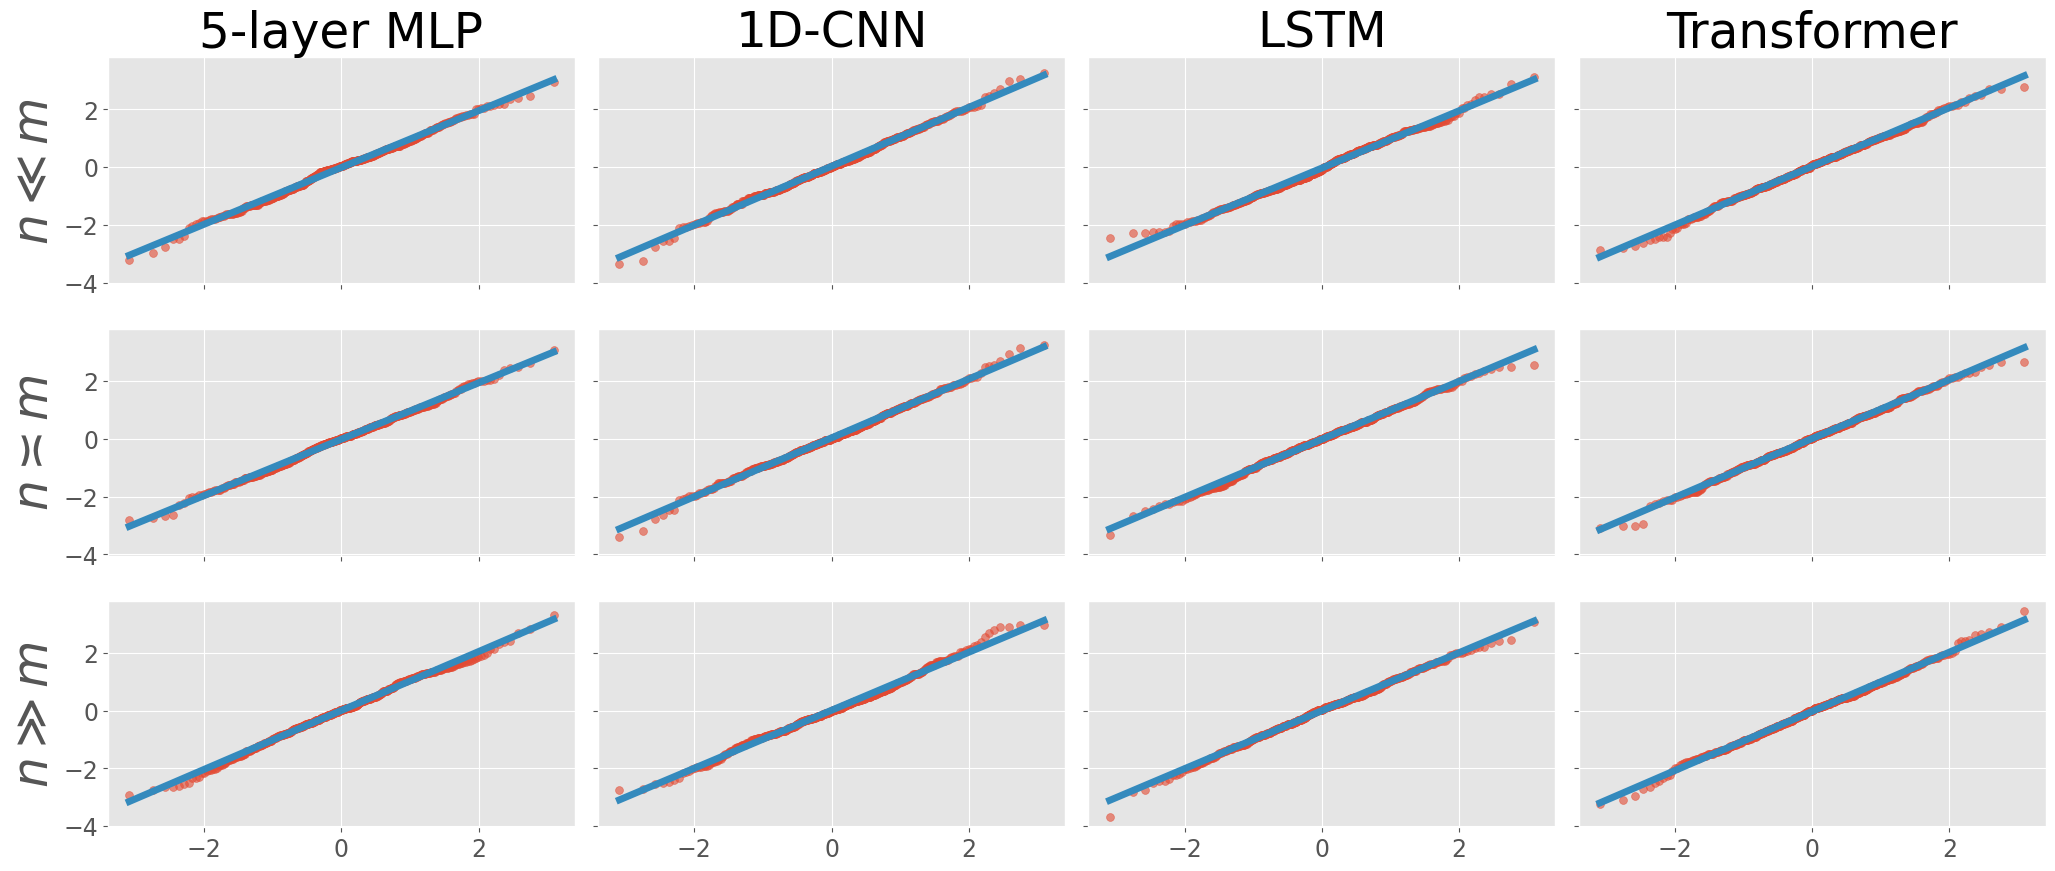

In [8]:
from scipy.stats import norm  # QQ用の理論分位（ppf）

paths = [glob("res/mat*mlp.csv")[0], glob("res/mat*cnn.csv")[0], glob("res/mat*rnn.csv")[0], glob("res/mat*tr.csv")[0]]

titles  = ["5-layer MLP", "1D-CNN", "LSTM", "Transformer"]
ylabels = [r"$n \ll m$", r"$n\asymp m$", r"$n\gg m$"]

fig, ax = plt.subplots(3, 4, figsize=(25, 10), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.05, hspace=0.2)

for i in range(4):
    df = pd.read_csv(paths[i], header=None).values  # 形状想定: (3, L)
    ax[0, i].set_title(titles[i], fontsize=35)
    for j in range(3):
        # サンプル分位
        x = np.asarray(df[j]).ravel()
        x_sorted = np.sort(x)
        n = x_sorted.size
        probs = (np.arange(1, n + 1) - 0.5) / n
        q_theor = norm.ppf(probs)  # 標準正規の理論分位

        # フィットした正規(N(mean, std^2))の基準線
        mean, std = x.mean(), x.std(ddof=0)
        y_fit = mean + std * q_theor

        # フィット線（N(mean, std^2)）
        ax[j, i].plot(q_theor, y_fit, color="C1", lw=5)
        # QQ散布図
        ax[j, i].scatter(q_theor, x_sorted, s=32, alpha=0.6)

        if i == 0:
            ax[j, i].set_ylabel(ylabels[j], fontsize=35)

        ax[j, i].tick_params(labelsize=17)

# 共通ラベル
# fig.text(0.5, 0.02, "Theoretical quantiles  (N(0,1))", ha="center", fontsize=24)
# fig.text(0.02, 0.5, "Sample quantiles", va="center", rotation="vertical", fontsize=24)

plt.savefig("asyN_qq.pdf", bbox_inches="tight", pad_inches=0.05)

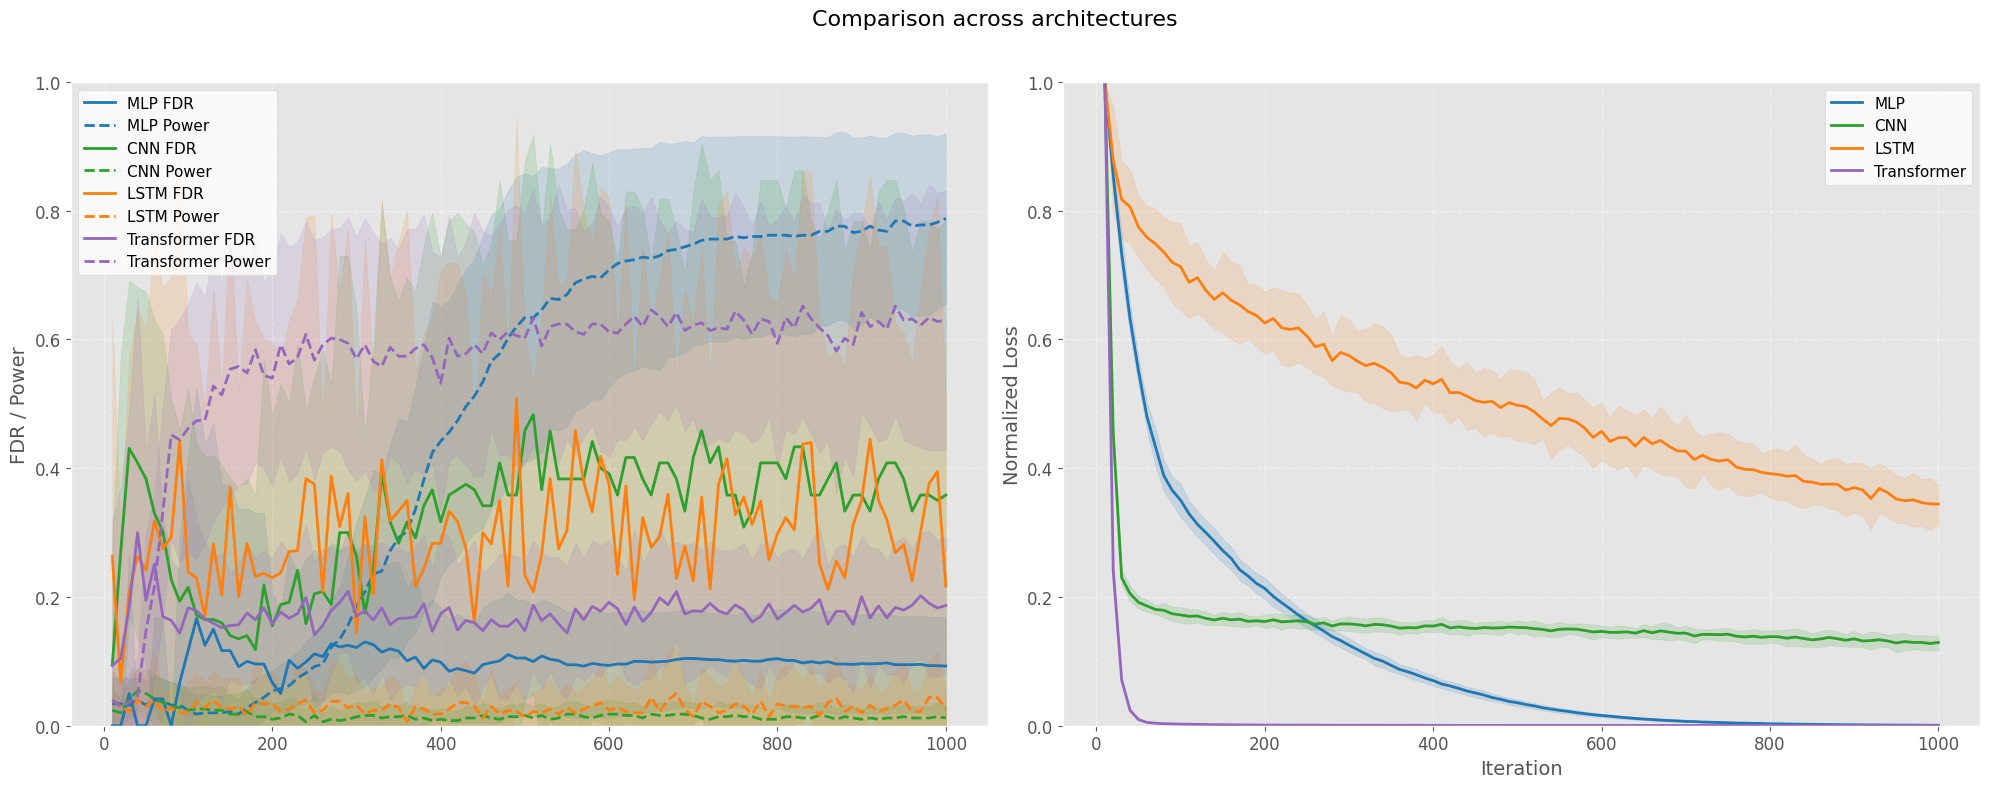

In [2]:
def load_stats(prefix, outdir="res"):
    fdr  = pd.read_csv(f"{outdir}/{prefix}_fdr.csv", header=None).values
    t2   = pd.read_csv(f"{outdir}/{prefix}_typeII.csv", header=None).values
    loss = pd.read_csv(f"{outdir}/{prefix}_loss.csv", header=None).values
    
    power = 1 - t2
    norm_loss = loss / loss[:, [0]]

    return {
        "fdr_mean":   fdr.mean(axis=0),
        "fdr_std":    fdr.std(axis=0),
        "power_mean": power.mean(axis=0),
        "power_std":  power.std(axis=0),
        "loss_mean":  np.nanmean(norm_loss,axis=0),
        "loss_std":   norm_loss.std(axis=0),
    }

def plot_all(outdir="res", T=500, compute_every=10, savefile="res/summary_all.pdf"):
    models = ["mlp", "cnn", "rnn", "tr"]
    labels = ["MLP", "CNN", "LSTM", "Transformer"]
    colors = ["#1f77b4", "#2ca02c", "#ff7f0e", "#9467bd"]  # モダン配色

    stats = {m: load_stats(m, outdir) for m in models}

    # 横軸 (compute_every ごと)
    K = T // compute_every
    steps = np.arange(1, K+1) * compute_every

    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True)

    # --- FDR + Power ---
    for m, label, c in zip(models, labels, colors):
        # FDR
        axes[0].plot(steps, stats[m]["fdr_mean"], lw=2, color=c, linestyle="-", label=f"{label} FDR")
        axes[0].fill_between(steps,
                             stats[m]["fdr_mean"] - stats[m]["fdr_std"],
                             stats[m]["fdr_mean"] + stats[m]["fdr_std"],
                             color=c, alpha=0.15)
        # Power
        axes[0].plot(steps, stats[m]["power_mean"], lw=2, color=c, linestyle="--", label=f"{label} Power")
        axes[0].fill_between(steps,
                             stats[m]["power_mean"] - stats[m]["power_std"],
                             stats[m]["power_mean"] + stats[m]["power_std"],
                             color=c, alpha=0.15)
    axes[0].set_ylabel("FDR / Power", fontsize=14)
    axes[0].set_ylim(0,1)
    axes[0].legend(frameon=True, facecolor="white", fontsize=11)

    # --- Loss ---
    for m, label, c in zip(models, labels, colors):
        axes[1].plot(steps, stats[m]["loss_mean"], lw=2, color=c, label=label)
        axes[1].fill_between(steps,
                             stats[m]["loss_mean"] - stats[m]["loss_std"],
                             stats[m]["loss_mean"] + stats[m]["loss_std"],
                             color=c, alpha=0.15)
    axes[1].set_ylabel("Normalized Loss", fontsize=14)
    axes[1].set_xlabel("Iteration", fontsize=14)
    axes[1].legend(frameon=True, facecolor="white", fontsize=11)
    axes[1].set_ylim(0,1);

    for ax in axes:
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.tick_params(labelsize=12)

    plt.suptitle("Comparison across architectures", fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    # plt.savefig(savefile, bbox_inches="tight")
    plt.show()

# 実行例
plot_all(outdir="res/iter_parallel", T=1000, compute_every=10, savefile="res/iter/iter.pdf")

# Elliptical

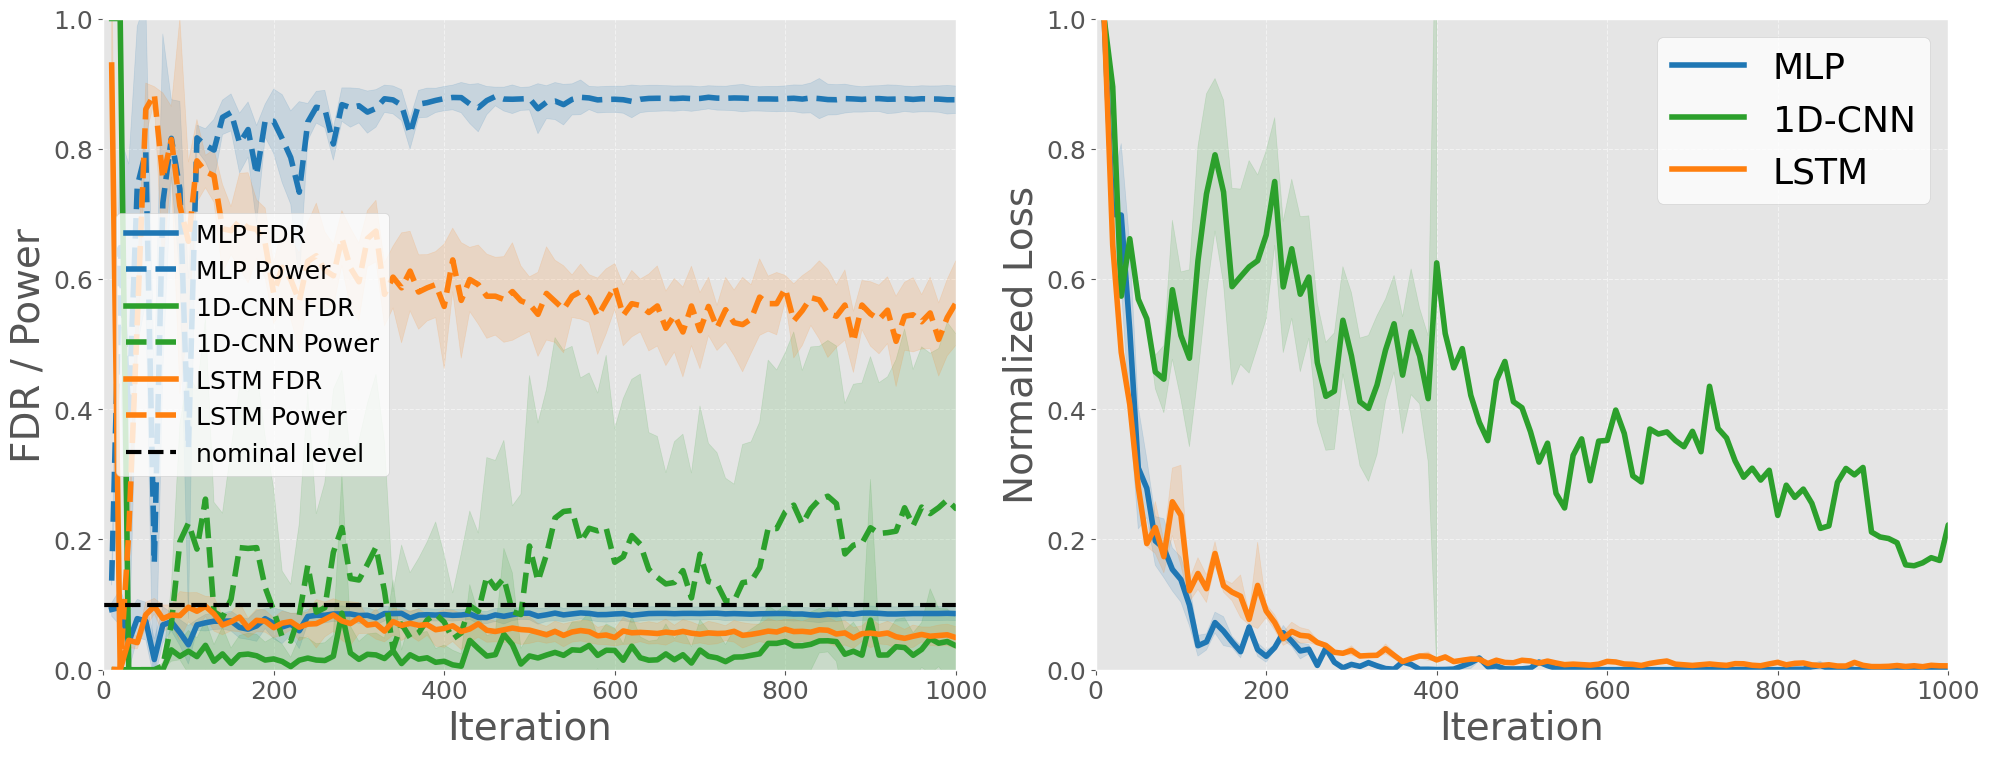

In [16]:
def load_stats(prefix, outdir="res"):
    fdr  = pd.read_csv(f"{outdir}/{prefix}_fdr.csv", header=None).values
    t2   = pd.read_csv(f"{outdir}/{prefix}_typeII.csv", header=None).values
    loss = pd.read_csv(f"{outdir}/{prefix}_loss.csv", header=None).values
    
    power = 1 - t2
    norm_loss = loss / loss[:, [0]]

    return {
        "fdr_mean":   fdr.mean(axis=0),
        "fdr_std":    fdr.std(axis=0),
        "power_mean": power.mean(axis=0),
        "power_std":  power.std(axis=0),
        "loss_mean":  np.nanmean(norm_loss,axis=0),
        "loss_std":   norm_loss.std(axis=0),
    }

def plot_all(outdir="res", T=500, compute_every=10, savefile="res/summary_all.pdf"):
    models = ["mlp", "cnn", "rnn"]
    labels = ["MLP", "1D-CNN", "LSTM"]
    colors = ["#1f77b4", "#2ca02c", "#ff7f0e"]  # モダン配色

    stats = {m: load_stats(m, outdir) for m in models}

    # 横軸 (compute_every ごと)
    K = T // compute_every
    steps = np.arange(1, K+1) * compute_every

    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True)

    # --- FDR + Power ---
    for m, label, c in zip(models, labels, colors):
        # FDR
        axes[0].plot(steps, stats[m]["fdr_mean"], lw=4, color=c, linestyle="-", label=f"{label} FDR")
        axes[0].fill_between(steps,
                             stats[m]["fdr_mean"] - stats[m]["fdr_std"],
                             stats[m]["fdr_mean"] + stats[m]["fdr_std"],
                             color=c, alpha=0.15)
        # Power
        axes[0].plot(steps, stats[m]["power_mean"], lw=4, color=c, linestyle="--", label=f"{label} Power")
        axes[0].fill_between(steps,
                             stats[m]["power_mean"] - stats[m]["power_std"],
                             stats[m]["power_mean"] + stats[m]["power_std"],
                             color=c, alpha=0.15)
    axes[0].set_ylabel("FDR / Power", fontsize=28)
    axes[0].set_xlabel("Iteration", fontsize=28)
    axes[0].set_ylim(0,1)
    axes[0].hlines(0.1, 0, 1000, color="black", lw=3, linestyle="--", label="nominal level")
    axes[0].legend(frameon=True, facecolor="white", fontsize=18)

    # --- Loss ---
    for m, label, c in zip(models, labels, colors):
        axes[1].plot(steps, stats[m]["loss_mean"], lw=4, color=c, label=label)
        axes[1].fill_between(steps,
                             stats[m]["loss_mean"] - stats[m]["loss_std"],
                             stats[m]["loss_mean"] + stats[m]["loss_std"],
                             color=c, alpha=0.15)
    axes[1].set_ylabel("Normalized Loss", fontsize=28)
    axes[1].set_xlabel("Iteration", fontsize=28)
    axes[1].legend(frameon=True, facecolor="white", fontsize=26)
    axes[1].set_ylim(0,1)

    for ax in axes:
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.tick_params(labelsize=18)
        ax.set_xlim(0,1000)

    # plt.suptitle("Comparison across architectures", fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(savefile, bbox_inches="tight")
    plt.show()

# 実行例
plot_all(outdir="res/iter_parallel_elpt", T=3000, compute_every=10, savefile="res/iter_parallel_elpt/iter_elpt.pdf")

## another theme

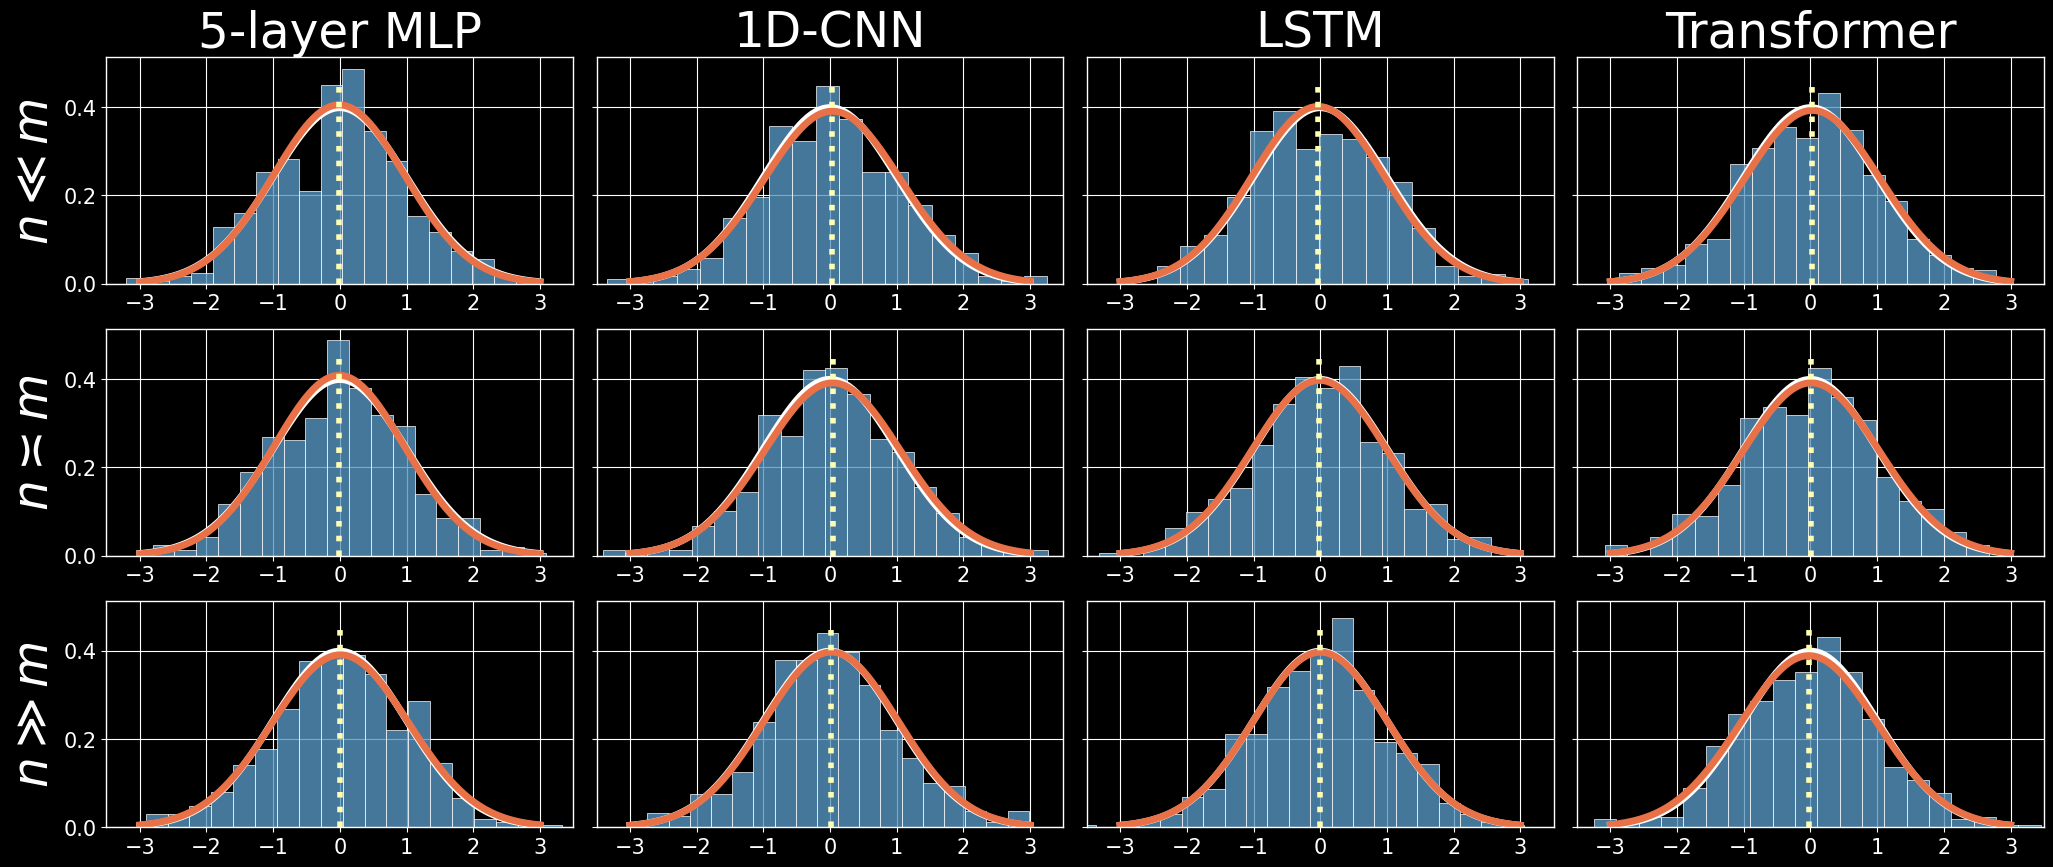

In [3]:
with plt.style.context('dark_background'):
    path = glob("res/*.csv")
    path = [glob("res/mat*mlp.csv")[0], glob("res/mat*cnn.csv")[0], glob("res/mat*rnn.csv")[0], glob("res/mat*tr.csv")[0]]
    path

    xxx = np.linspace(-3,3,100)
    titles = ["5-layer MLP", "1D-CNN", "LSTM", "Transformer"]
    ylabels = [r"$n \ll m$", r"$n\asymp m$", r"$n\gg m$"]
    fig, ax = plt.subplots(3,4,figsize=(25, 10), sharey=True)
    plt.subplots_adjust(wspace=0.05, hspace=0.2);
    for i in range(4):
        df = pd.read_csv(path[i], header=None).values
        ax[0,i].set_title(titles[i], fontsize=35);
        for j in range(3):
            ax[j,i].plot(xxx, np.exp(-xxx**2/2)/np.sqrt(2*np.pi), color="white", lw=5);
            sns.histplot(df[j], stat="density", color=(87/255,150/255,195/255), alpha=0.8, ax=ax[j,i]);
            mean, std = np.mean(df[j]), np.std(df[j])
            ax[j,i].plot(xxx, np.exp(-(xxx-mean)**2/2/std**2)/np.sqrt(2*np.pi)/std, color=(232/255,113/255,71/255), lw=5);
            ax[j,i].vlines(mean, 0, 0.45, linestyle="dotted", lw=4, color="C1");
            ax[j,0].set_ylabel(ylabels[j], fontsize=35);
            ax[j,i].set_xlim(-3.5,3.5);
            ax[j,i].tick_params(labelsize=15);
    # plt.show()
    plt.savefig('asyN.png', bbox_inches='tight')